# ADADelta and ADAM Optimizers

## Part I: Core Problem
The main purpose of an optimization problem: finding model parameters ($ \theta $) that minimize a cost function ($ J(\theta) $). However, There are presenting significant challenges for simple optimization algorithms. Traditional methods like **Gradient Descent (SGD)** struggle with several key issues:

- **Difficult Navigation**: The presence of numerous local minima and, more commonly, saddle points can cause optimizers to slow down or get stuck, hindering convergence.
- **Gradient Scaling Issues**: In deep networks, gradients can shrink exponentially (vanish) or grow uncontrollably (explode), making stable training difficult.
- **Inflexible Learning Rate**: GD uses a single, fixed learning rate for all parameters. This is inefficient, as a rate that is too small leads to slow convergence, while one that is too large can cause the loss to diverge. Manually tuning this hyperparameter is a difficult and time-consuming process.

Above drawback is clearly seen when we meet a complex function which might provide a lot of difficulty for these simple optimization algorithm

Let consider a complex function 

$$
f(x) = 0.1x^2 + 2\cos(x)
$$

In [158]:
import numpy as np
import torch
from d2l import torch as d2l

def f(x):  # Objective function
    return 0.1 * x**2 + 2 * np.cos(x)

def f_grad(x):  # Gradient (derivative) of the objective function
    return 0.2 * x - 2 * np.sin(x)

We start to implement the straightforward formula of Gradient Descent, which is 

$$
\theta = \theta - \alpha \nabla_\theta J(\theta)
$$

Where:  
- $\theta$ — parameter vector  
- $\alpha$ — learning rate  
- $J(\theta)$ — cost function  
- $\nabla_\theta J(\theta)$ — gradient of the cost function with respect to $\theta$ 

In [159]:
def gd(eta, f_grad, iteration):
    x = 20.0
    results = [x]
    for i in range(iteration):
        x -= eta * f_grad(x)
        results.append(float(x))
    if iteration >= 100: 
        print(f'epoch 100, x: {x:f}')
    else:
        print(f'epoch 10, x: {x:f}')
    return results


def show_trace(results, f):
    n = max(abs(min(results)), abs(max(results)))
    f_line = torch.arange(-n, n, 0.01)
    d2l.set_figsize()
    d2l.plot([f_line, results], [[f(x) for x in f_line], [
        f(x) for x in results]], 'x', 'f(x)', fmts=['-', '-o'])

epoch 10, x: 14.199781


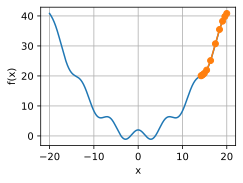

In [160]:
results = gd(0.2, f_grad, 10)
show_trace(results, f)

epoch 100, x: 8.423204


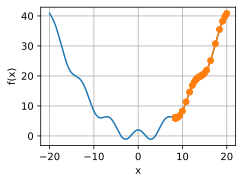

In [161]:
results = gd(0.2, f_grad, 100)
show_trace(results, f)

epoch 100, x: 8.423204


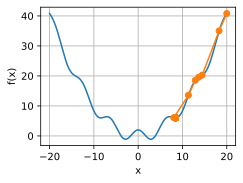

In [162]:
results = gd(0.8, f_grad, 100)
show_trace(results, f)

By exam the different learning rate and a complex function where exists multiple saddle point, local minima and it also have even 2 global minima values which is a big challenge for a simple optimization algorithm. Based on above plots, we can easily see that 
1. Within the learning rate **$\eta$ = 0.2**, which is a safer option, the steps consistently move downhill towards the nearest minimum. The path is smooth and direct but it might be slightly too slow, so it doesn't get very close to the local minimum within the 10 epochs but we can see it can reach the local minimum value within 100 epochs. This learning rate is safe but not very aggressive 
2. In constract, the learning rate **$\eta$ = 0.8**, which is too high and we can clearly see at the very first step that it jump dramatically. This fluctuate jump is a classic sign that the learning rate is too large for curvature of the function. The optimization path is inefficient and unstable 





So, To overcome the inflexible learning rate problems, the adaptive methods like **AdaDelta & ADAM** can help us, while **AdaDelta** provides the adaptive learning rates per parameter of **Adagrad**, but prevents the learning rate from decaying too aggressively, and **ADAM** provides a learning-rate-free method

## Part II: Pre-requisites 

### 2.1 AdaGrad 

AdaGrad stands for **Adaptive Gradient Algorithm**, it is an optimization algorithm that is designed to adapt the learning rate for each parameter. Instead of considering the learning rate for every parameters as the same, which we can see it was expressed within standard formula of Gradient Descent. Adagrad adapts chooses a dynamic way which is giving each parameter its own learning rate. To achieve this, AdaGrad maintains a variable called accumulator $s(i,t)$ for each parameter, which is updated at every step by summing with the square of the current gradient 
$$
s(i, t+1) = s(i, t) + (\partial_i f(\mathbf{x}))^2
$$

This sum of past squared gradients is then used to scale the learning rate in the final parameter update rule
$$
\theta = \theta - \frac{\eta}{\sqrt{s(i, t) + \epsilon}} (\partial_i f(\mathbf{x}))
$$


epoch 91, x: 8.831097
epoch 92, x: 8.809231
epoch 93, x: 8.788735
epoch 94, x: 8.769505
epoch 95, x: 8.751446
epoch 96, x: 8.734472
epoch 97, x: 8.718506
epoch 98, x: 8.703474
epoch 99, x: 8.689313


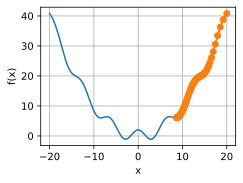

In [163]:
def adagrad(eta, f_grad, iteration):
    x = 20.0
    accumlator = 0
    results = [x]

    # A small epsilon value to prevent division by zero 
    eps = 1e-6

    for i in range(iteration):
        grad = f_grad(x)
        accumlator += grad**2
        x -= eta * grad/np.sqrt(accumlator + eps)
        if i > 90: 
            print(f'epoch {i}, x: {x:f}')
        results.append(float(x))
    
    return results
    
inital_learning_rate = 0.8
results = adagrad(inital_learning_rate, f_grad, 100)
show_trace(results, f)


Based on above plot, we can easily see the adaptive of the Adagrad. As its step size is calculated as $\frac{\eta}{\sqrt{s(i, t) + \epsilon}}$ so 
- **In steep areas (large gradient)**: The sum of squared gradients grow quickly, which make an accumulator is dramatically huge and then it rapidly shrinks the learning rate. But as we divide the square root of it, it acts as a brake, which prevent the overshooting like GD does 
- **In the flat areas (small gradient)**: The sum of squared gradients still grow but slightly, which then the step size is bigger as the learning rate divide small value which allow us to confidently take a bigger step

If we take a look on the same function in Gradient Descent where the learning rate $\eta$ also is 0.8 above, we can see the differentiate between Gradient Descent and AdaGrad, one side is overshooting and unstable and another side is more-stable and stick with the curve quite precisely 

#### 2.1.2 Limitation

The weakness of AdaGrad can be exposed within this formula 

$$
s(i, t+1) = s(i, t) + (\partial_i f(\mathbf{x}))^2
$$

Where $(\partial_i f(\mathbf{x}))^2 > 0$ and the $s(i, t)$ keep adding up, which make the the accumulator of historical gradient keeps growing over time, so it can become a really large value over many iterations. Consequently, the step size can become so tiny that the model's parameters stop updating in any meaningful way, preventing it from converging to an optimal solution

Below is an simulation about the rapidly decrease of learning rate within AdaGrad 


Epoch   | Current X          | Gradient           | Step Size         
----------------------------------------------------------------------
1       | 19.200000          | 12000.000000       | 0.000067          
2       | 18.657845          | 11059.200000       | 0.000049          
3       | 18.226621          | 10443.455634       | 0.000041          
4       | 17.860677          | 9966.291030        | 0.000037          
5       | 17.538948          | 9570.113192        | 0.000034          
6       | 17.249695          | 9228.441353        | 0.000031          
7       | 16.985591          | 8926.559775        | 0.000030          
8       | 16.741702          | 8655.308965        | 0.000028          
9       | 16.514521          | 8408.537501        | 0.000027          
10      | 16.301448          | 8181.881902        | 0.000026          


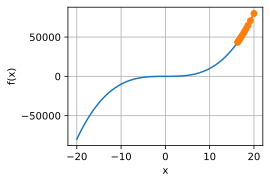

In [164]:
def f_steep(x):
    return 10 * x ** 3

def f_steep_grad(x): 
    return 30 * x ** 2


def adagrad_step_size_tracking(eta, f_grad, iteration):
    x = 20.0
    accumlator = 0
    results = [x]
    # A small epsilon value to prevent division by zero 
    eps = 1e-6
    print(f"{'Epoch':<7} | {'Current X':<18} | {'Gradient':<18} | {'Step Size':<18}")
    print("-" * 70)

    for i in range(iteration):
        grad = f_grad(x)
        accumlator += grad**2
        effective_lr = eta  / np.sqrt(accumlator + eps)
        x -= effective_lr * grad
        results.append(x)
        print(f"{i+1:<7} | {x:<18.6f} | {grad:<18.6f} | {effective_lr:<18.6f}")
    
    return results
    

inital_learning_rate = 0.8
results = adagrad_step_size_tracking(inital_learning_rate, f_steep_grad, 10)
show_trace(results, f_steep)

    


### 2.2 EMA 

EMA stand for **Exponential Moving Average** which is a statistical method used to create a smoothed average of a sequence of data. It places more weight on the most recent data points, with the influence of older points decreasing exponentially over time. Within the optimizers such as Adam, AdaDelta, EMA is used to **stabilize training**. Instead of using the raw, often noisy gradient at a single step, these optimizers use an EMA to estimate the gradient's direction and magnitube, helping the optimizer to navigate the loss landscape **more smoothly**

The EMA can be expressed in the form of a formula as follows 

$$
v_t = \beta \cdot v_{t-1} + (1 - \beta) \cdot x_t
$$

Where:
* $v_t$ is the new EMA at the current timestep $t$.
* $v_{t-1}$ is the EMA from the previous timestep $t-1$.
* $x_t$ is the new data point at the current timestep (e.g., the current gradient).
* $\beta$ (beta) is the **decay rate** or smoothing factor, a value between 0 and 1.

#### 2.2.1 Implementation

First, I would like to define the EMA function which use to calculate the EMA value

In [165]:
import matplotlib.pyplot as plt

def calculate_ema(data, beta):
    ema_value = [data[0]]

    for i in range(1, len(data)):
        new_ema = beta * ema_value[-1] + (1 - beta) * data[i]
        ema_value.append(new_ema)
    
    return ema_value

# Generate the test data
time = np.arange(0, 100)
noisy_data = np.sin(time * 0.2) + np.random.randn(len(time)) * 0.4




This is the heart of EMA which we choose the value of beta parameter 
- $\beta = 0.9$ which indicate that we remember 90% of the historical data and only reliable on 10% of recent data 
- In the other hand, where $\beta = 0.6$, which we provide more balance within 60% of the historical data and 40% of recent data 

In [166]:
beta_smooth = 0.9
ema_smooth = calculate_ema(noisy_data, beta_smooth)

beta_responsive = 0.6
ema_responsive = calculate_ema(noisy_data, beta_responsive)

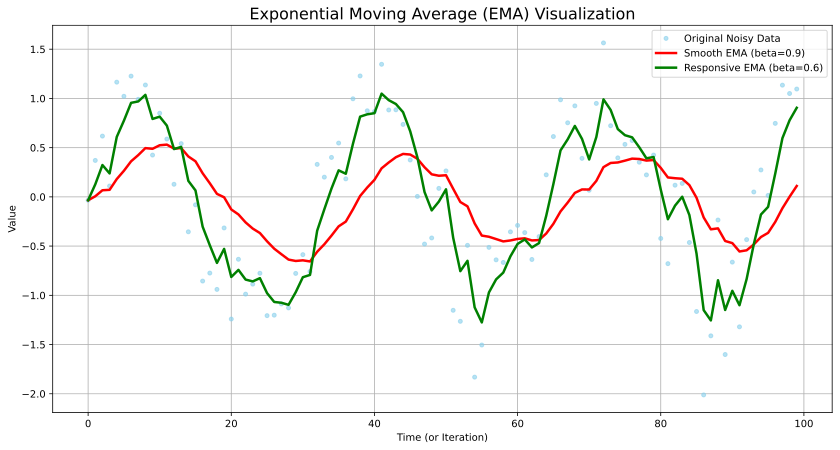

In [167]:
plt.figure(figsize=(14, 7))

# Plot the original noisy data
plt.plot(time, noisy_data, 'o', color='skyblue', markersize=4, alpha=0.6, label='Original Noisy Data')

# Plot the smooth EMA
plt.plot(time, ema_smooth, color='red', linewidth=2.5, label=f'Smooth EMA (beta={beta_smooth})')

# Plot the responsive EMA
plt.plot(time, ema_responsive, color='green', linewidth=2.5, label=f'Responsive EMA (beta={beta_responsive})')

plt.title('Exponential Moving Average (EMA) Visualization', fontsize=16)
plt.xlabel('Time (or Iteration)')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

So,
- for the $\beta = 0.9$, as it contains more historical data, and really less on the recent data so it ignores most of the small, noisy spikes. Because of that, we could see the line is not really fit all the data 
- For the $\beta = 0.6$, the line has less memory and is heavily influenced by the latest piece of information. It reacts quickly in the data so that why we could see that it fit the to most of data 

## Part III: AdaDelta & ADAM

### 3.1 AdaDelta - AdaGrad's Improvement

AdaDelta is a more complex optimization algorithm developed to get rid of the primary weakness of AdaGrad. To achieve that, AdaDelta uses 2 variables to capture the history data.

Instead of summing all the past gradients like AdaGrad, AdaDelta utilize an EMA which was expressed above, to only considers a recent window of gradients, preventing the denominator from growing infinite.

1. **Average of Past Squared Gradient**: Within the concept of EMA, this one, we put more rate to the new value and less rate for the historical data which is the similar with situation that $\beta = 0.6$ above so that we can have a better fit
$$
s_t = \rho s_{t-1} + (1 - \rho)g_t^2
$$

2. **Average of Past Squared Updates**: This parameter define the size of the change and also use the concept of EMA so that we can calculate a better step size which can replace the learning rate

$$
\Delta x_t = \rho \Delta x_{t-1} + (1 - \rho)g_t'^2
$$

Above formula about $\Delta x_t$, we have a rescaled gradient which use to improve an update. So within the $g_t$, there is an interesting point is that, unlike its pioneer AdaGrad, it gets rid of the traditional learning rate ($\eta$) by replacing it with a ratio of the 2 averages described above. So, The update step is calculated with a rescaled gradient, $g'_t$
$$
\theta = \theta - \frac{\sqrt{\Delta x_{t-1} + \epsilon}}{\sqrt{s_t + \epsilon}} \odot g_t
$$


#### 3.1.1 Implementation 
Here is the implementation of AdaDelta, which maintains 2 state variables $s_t$ $\Delta x_t$. For fully implementation and testing, can refer to this Github repo: https://github.com/hu1909/AdaDelta_and_ADAM/blob/main/implementation/AdaDelta-implementation.ipynb

Epoch   | Current X          | Gradient           | Step Size         
----------------------------------------------------------------------
992     | 12.181076          | 4458.169128        | 0.000002          
993     | 12.171761          | 4451.358282        | 0.000002          
994     | 12.162448          | 4444.553233        | 0.000002          
995     | 12.153135          | 4437.753983        | 0.000002          
996     | 12.143823          | 4430.960534        | 0.000002          
997     | 12.134511          | 4424.172891        | 0.000002          
998     | 12.125201          | 4417.391055        | 0.000002          
999     | 12.115892          | 4410.615030        | 0.000002          
1000    | 12.106583          | 4403.844819        | 0.000002          


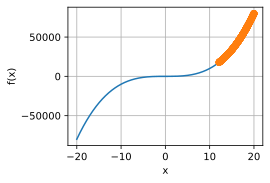

In [168]:
def adaDelta(beta, f_grad, iteration):
    x = 20.0 
    results = [x]
    s = 0.0
    delta = 0.0 
    eps = 1e-6


    print(f"{'Epoch':<7} | {'Current X':<18} | {'Gradient':<18} | {'Step Size':<18}")
    print("-" * 70)
    
    for i in range(iteration):
        grad = f_grad(x)
        s = beta * s + (1- beta) * grad**2 
        step_size = (np.sqrt(delta + eps) / np.sqrt(s + eps))
        dx =  step_size * grad
        delta = beta * delta + (1 - beta) * dx**2

        x -= dx 
        if i > 990: 
            print(f"{i+1:<7} | {x:<18.6f} | {grad:<18.6f} | {step_size:<18.6f}")
        results.append(float(x))
    return results

inital_beta = 0.8
results = adaDelta(inital_beta, f_steep_grad, 1000)
show_trace(results, f_steep)
    

The plot illustrates the main strength of AdaDelta as it automatically adapts its step size within needing a learning rate hyperparameter. We could see the optimization path (the orange line) is incredibly smooth. It moves consistently downhill without any of the wild bouncing or overshooting as we saw in Gradient Descent. 

Also as remove the drawback of AdaGrad, the step size of each iteration is more stable, not tiny value and stick perfectly to the curve of the function even if it running through a complex function which provide a huge gradient 

### 3.2.2 Limitation 

While the AdaDelta come to remove the drawback of AdaGrad which is decaying learning rate, above example also indicate a critical drawback of the AdaDelta where the initial gradient is huge already. In this case, $\Delta x_t$ parameter for the update size can't grow fast enough for compensate which leads to the step size becoming almost zero

So to overcome this one, ADAM algorithm which combines a similar mechanism with momentum, is generally preferred

### 3.2 ADAM - Adaptive Moment Estimation 

ADAM algorithm was developed by integrating several effective optimization techniques. Within the ADAM we can have some techniques such as 
1. **Mini-batching**: Using small batches for data, parallelized processing 
2. **Momentum**: Combine the history of the past gradients
3. **Pre-coordinate Scaling**: Adjusting the learning rate for each parameter separately which kind of similar with AdaDelta and AdaGrad 

The core idea about the ADAM to combine these features together, it also use EMA to track the first moment (the momentum of the gradient) and the second moment (the uncentered variance of the gradient). These 2 moments was indicated within 2 state variables
1. **Momentum vector ($ \mathbf{v}_t $)**: Since $\mathbf{v}_t$ contains the average direction of all recent gradients so if the gradients has been consistently in one direction, the $\mathbf{v}_t$ will also point strongly to that direction, in this case the value of $\mathbf{v}_t$ is **high** thank to EMA. If the gradients have been back and forth, their positive and negative values will cancel each other out in the average, which provide the value is **smaller** 

$$
\mathbf{v}_t \leftarrow \beta_1 \mathbf{v}_{t-1} + (1 - \beta_1)\mathbf{g}_t
$$

2. **Second moment vector ($ \mathbf{s}_t $)**: $\mathbf{s}_t$ is average of the past squared gradient as squaring the gradient, we will cannot track the positive and negative of value which indicate the direction. So it only tracks the magnitude or variance of the gradients 

$$
\mathbf{s}_t \leftarrow \beta_2 \mathbf{s}_{t-1} + (1 - \beta_2)\mathbf{g}_t^2
$$

Since the vector $v_0$ and $s_0$ are initialized to zero, which can make the intial estimates are biased towards 0. To fix this, Adam applies a bias correction which is the most significant during the early stages of training and become negligible as $t$ increase
$$
\hat{\mathbf{v}}_t = \frac{\mathbf{v}_t}{1 - \beta_1^t} \quad \text{and} \quad \hat{\mathbf{s}}_t = \frac{\mathbf{s}_t}{1 - \beta_2^t}
$$

So within the corrected estimates, Adam compute the final update by first rescales the gradient by dividing the momentum estimate by the square root of the second moment estimate

$$
 \theta = \theta - \frac{\eta \hat{\mathbf{v}}_t}{\sqrt{\hat{\mathbf{s}}_t} + \epsilon} \odot g_t
$$

As the $\mathbf{v}_t$ in the numerator, we can see that if the value of $\mathbf{v}_t$ is high which indicate strongly go in one direction, then we keep going that direction and if the smaller value of $\mathbf{v}_t$ then we have to careful at our speed and direction -> This parameter indicate the **speed and direction**

In the other hand, the $\mathbf{s}_t$ in the denominator, which indicate that if the value is consistently large then when we divide it, the step will be smaller. In constract, if the gradient's value is small, then the step will be larger -> This parameter indicate the **step size** of each parameter


### 3.2.1 Implementation


epoch 10, x: -51.024103


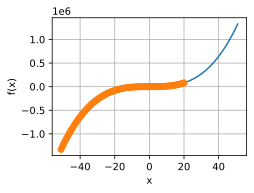

In [169]:
def adam(eta, beta1,beta2, f_grad, iteration):
    x = 20.0 
    results = [x]
    eps = 1e-6
    v = 0
    s = 0 

    for i in range(1, iteration + 1): # Prevent with multiple with i become zero
        grad = f_grad(x)
        v = beta1 * v + (1-beta1) * grad
        s = beta2 * s + (1-beta2) * grad**2 

        v_hat = v / (1-beta1**i)
        s_hat = s / (1-beta2**i)

        x -= eta * v_hat / (np.sqrt(s_hat) + eps)
        
        results.append(float(x))

    print(f'epoch 10, x: {x:f}')
    return results

inital_learning_rate = 0.8
results = adam(inital_learning_rate, 0.6, 0.6, f_steep_grad, 100)
show_trace(results, f_steep)

### 3.2.2 Limitation and Improvement
Take a closer look on the second parameter
$$
\mathbf{s}_t \leftarrow \mathbf{s}_{t-1} + (1 - \beta_2) (\mathbf{g}_t^2 - \mathbf{s}_{t-1})
$$
The problem come from the term $(\mathbf{g}_t^2 - \mathbf{s}_{t-1})$. If the new squared gradient $\mathbf{g}_t^2$ has very high variance or if the gradient updates are sparse, this difference can become very large. When this happens, $\mathbf{s}_t$ can change too rapidly, might miss its history of past gradient information quickly. This problem can prevent the model from converging properly



We can obviously see in the above example which have a huge inital gradient. In this case, I would like to introduce new improvement - **the Yogi** which its core idea is control the magnitude of this update, so it will replace this term $(\mathbf{g}_t^2 - \mathbf{s}_{t-1})$ with this one 

$$
\mathbf{g}_t^2 \odot \text{sgn}(\mathbf{g}_t^2 - \mathbf{s}_{t-1})
$$

By doing this, the magnitude of the update no longer depends on how much $\mathbf{g}_t^2$ deviates. This prevents the explosive updates and leads to more stable training.

This result update the second moment like this 

$$
\mathbf{s}_t \leftarrow \mathbf{s}_{t-1} + (1 - \beta_2)\mathbf{g}_t^2 \odot \text{sgn}(\mathbf{g}_t^2 - \mathbf{s}_{t-1})
$$

epoch 10, x: 0.851991


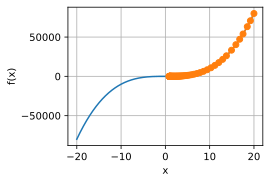

In [170]:
def adam_yogi(eta, beta1,beta2, f_grad, iteration):
    x = 20.0 
    results = [x]
    eps = 1e-6
    v = 0
    s = 0 

    for i in range(1, iteration + 1): # Prevent with multiple with i become zero
        grad = f_grad(x)
        v = beta1 * v + (1-beta1) * grad
        s = s + (1 - beta2) * np.sign(grad**2 - s) * grad**2

        v_hat = v / (1-beta1**i)
        s_hat = s / (1-beta2**i)

        x -= eta * v_hat / (np.sqrt(s_hat) + eps)
        
        results.append(float(x))

    print(f'epoch 10, x: {x:f}')
    return results

inital_learning_rate = 0.8
results = adam_yogi(inital_learning_rate, 0.6, 0.6, f_steep_grad, 100)
show_trace(results, f_steep)
    

Based on the standard Adam algorithm, we could see that within the function have a huge gradient at the initial time, this make the $\mathbf{s}_t$ to explode which crushes the learning rate for all future steps. However, the value of $\mathbf{v}_t$ from the first step remains high, resulting in one giant, uncontrolled leap that overshoots the minimum and leads in negative zone 

Besides that, the improvement with Yogi keep the learning rate more stable. This allows it to take a much more controlled, smaller step, preventing the overshoot and keeping its value positive

## Part IV: Application and User Cases

Both optimizers have been successfully applied to a variety of computer science problems, including Natural Language Processing (NLP) and Computer Vision (CV). Their strengths make them suitable for different scenarios depending on many aspects.

- **ADADelta** is used in tasks where gradients are sparse or unstable, such as speech recognition systems  and early sequence modeling problems. 

- **ADAM** is the default optimizer for many state-of-the-art models which can be used efficiently in many specific branch of AI application such as NLP, Computer vision or reinforcement learning. It performs especially well in large-scale datasets like ImageNet and Wikipedia corpora.

In educational and research contexts, both optimizers are implemented from scratch to teach adaptive optimization. ADADelta helps illustrate unit-corrected updates, while ADAM demonstrates how momentum and scaling improve convergence in real-world models. 

## Part V: Conclusion

**ADADelta** and **ADAM** represent vital changes in the evolution of optimization algorithms. Both build upon the limitations of earlier methods like Adagrad by introducing exponential moving averages. **ADADelta** simplifies training by leveraging the need of adaptive learning rate. However, its convergence can be slower and less stable in complex scenarios.

ADAM, on the other hand, combines the strengths of momentum and adaptive learning rates with bias correction, making it one of the most robust and widely adopted optimizers today.

In practice, **ADAM is the recommended default optimizer** for most deep learning tasks due to its reliability and speed, while **ADADelta remains a valuable option** for specific cases where minimal hyperparameter tuning or sparse gradient updates are critical. A solid understanding of both is really helpful to choose the right tool based on task requirements and training behavior.

## Part VI: Exercise with ADADelta & ADAM

### AdaDelta Practical 

#### 1. Adjust the value of ρ. What happens?

Epoch   | Current X          | Gradient           | Step Size         
----------------------------------------------------------------------
992     | 8.423204           | 0.000000           | 1.000000          
993     | 8.423204           | 0.000000           | 1.000000          
994     | 8.423204           | 0.000000           | 1.000000          
995     | 8.423204           | 0.000000           | 1.000000          
996     | 8.423204           | 0.000000           | 1.000000          
997     | 8.423204           | 0.000000           | 1.000000          
998     | 8.423204           | 0.000000           | 1.000000          
999     | 8.423204           | 0.000000           | 1.000000          
1000    | 8.423204           | 0.000000           | 1.000000          


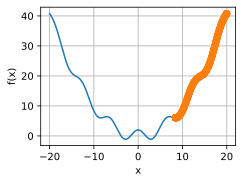

In [171]:
inital_beta = 0.2
results = adaDelta(inital_beta, f_grad, 1000)
show_trace(results, f)

Epoch   | Current X          | Gradient           | Step Size         
----------------------------------------------------------------------
992     | 12.794994          | 2.082890           | 0.006283          
993     | 12.781776          | 2.105726           | 0.006277          
994     | 12.768426          | 2.128868           | 0.006271          
995     | 12.754942          | 2.152319           | 0.006265          
996     | 12.741322          | 2.176077           | 0.006259          
997     | 12.727565          | 2.200144           | 0.006253          
998     | 12.713670          | 2.224518           | 0.006247          
999     | 12.699634          | 2.249200           | 0.006240          
1000    | 12.685457          | 2.274188           | 0.006234          


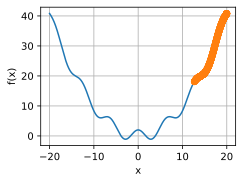

In [172]:
inital_beta = 0.9
results = adaDelta(inital_beta, f_grad, 1000)
show_trace(results, f)

Above 2 plot, I have choose the $\beta$ value as 0.2 and 0.9. So we can understand that within the concept EMA, the $\beta$ responsible for memorizing the historical data, if the high value of $\beta$ then the update will based more in historical data and in the other hand, it based more in the recent data. 

So with the $\beta = 0.9$, we only use 10% of recent data which we coul see that it is very smooth, but slower path to the minimum but with $\beta = 0.2$ where it use 80% of recent data, this alow it converge faster and can reach the minimum faster 

#### 2. Implement ADADelta without g'_t
$g'_t$ is a rescaled gradient in AdaDelta which is the core component of the algorithm. Because within this $g'_t$ we can automatically adapt the learning rate for each parameter so without it, it could revert to simpler one such as AdaGrad or Basic Gradient Descent. So I would say that it's not really a good idea if we remove the core component which define the algorithm

#### 3. Is ADADelta really learning-rate free?

Yes, AdaDelta is learning-rate free because we can easily see in the formula that AdaDelta remove the need of the learning rate and replace it with dynamically calculated ratio 

$$
\frac{\text{RMS of previous parameter updates}}{\text{RMS of recent gradients}}
$$

Within this ratio we can adapt with the step size of each parameter


#### 4. Compare ADADelta, Adagrad, and RMSProp
- **Adagrad**: Learning rate decays over time and can halt learning.
- **RMSProp**: Fixes Adagrad with EMA of gradients but still needs η.
- **ADADelta**: Adds EMA of updates to remove η.
- **Convergence**: ADADelta and RMSProp outperform Adagrad in long tasks; ADAM often converges even faster.

### ADAM Practical 

#### 1. Adjust learning rate η and analyze


epoch 10, x: 8.394504


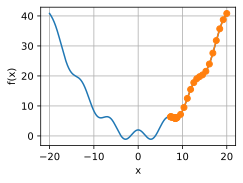

In [173]:
inital_learning_rate = 0.8
results = adam(inital_learning_rate, 0.6, 0.6, f_grad, 100)
show_trace(results, f)

epoch 10, x: 8.392865


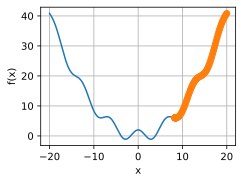

In [174]:
inital_learning_rate = 0.2
results = adam(inital_learning_rate, 0.6, 0.6, f_grad, 100)
show_trace(results, f)

This table indicates that a higher learning rate resulted in a faster decrease in loss because the learning rate acts as a step size.

In the Adam algorithm, the rescaled gradient calculation is:

$$
g'_t = \frac{\eta \hat{v}_t}{\sqrt{\hat{s}_t} + \epsilon}
$$

where $ \frac{\hat{v}_t}{\sqrt{\hat{s}_t} + \epsilon} $ calculates the direction and adaptive scaling of the update,  
and then the $ \eta $ scales the magnitude of that step. So within:

- Small learning rate (0.2): more cautious steps in the correct direction. The loss decreases steadily  
- Large learning rate (0.9): more aggressive steps in the same direction


#### 2. Rewrite momentum and second moment updates such that it does not require bias correction
The purpose of bias correction is to overcome the moveing average for momentum and variance are initialized as vectors of zeros. This could makes the estimate inaccurate during the first few steps of training

I've implement a version of Adam with no bias correction

epoch 10, x: 0.049961


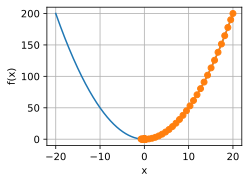

In [175]:
def f_no_bias(x):
    return 0.5 * x**2

# The gradient of the steep function
def f_no_bias_grad(x):
    return x

def adam_no_bias(eta, beta1,beta2, f_grad, iteration):
    x = 20.0 
    results = [x]
    eps = 1e-6
    v = 0
    s = 0 

    for i in range(1, iteration + 1): # Prevent with multiple with i become zero
        grad = f_grad(x)
        v = beta1 * v + (1-beta1) * grad
        s = beta2 * s + (1-beta2) * grad**2 

        # v_hat = v / (1-beta1**i)
        # s_hat = s / (1-beta2**i)

        x -= eta * v / (np.sqrt(s) + eps)
        
        results.append(float(x))

    print(f'epoch 10, x: {x:f}')
    return results

inital_learning_rate = 0.8
results = adam_no_bias(inital_learning_rate, 0.6, 0.6, f_no_bias_grad, 100)
show_trace(results, f_no_bias)


epoch 10, x: 0.142290


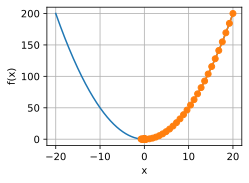

In [176]:
inital_learning_rate = 0.8
results = adam(inital_learning_rate, 0.6, 0.6, f_no_bias_grad, 100)
show_trace(results, f_no_bias)


The different is that at the very begining, the inital estimate for $v$ and $s$ are close to zero, the update steps are heavily suppressed. Consequently, the step is much slower start

#### 3. Why reduce learning rate during convergence?
As convergence nears, gradient noise dominates. Reducing η helps prevent oscillation and enables fine-grained convergence — this is known as learning rate scheduling.


#### 4. When Adam diverges but Yogi converges
High-variance gradients can cause ADAM’s second-moment estimate to explode. Yogi controls this using the sign of the difference.

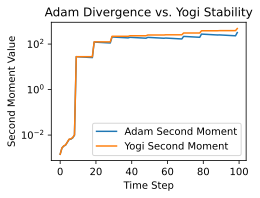

: 

In [ ]:
def gradient_generator(t):
    if t % 10 == 0:
        return np.random.uniform(10, 100)
    else:
        return np.random.uniform(0.1, 0.5)

beta2, num_steps = 0.99, 100
s_adam, s_yogi = 0, 0
adam_list, yogi_list = [], []

for t in range(1, num_steps + 1):
    grad = gradient_generator(t)
    s_adam = s_adam + (1 - beta2) * (grad**2 - s_adam)
    s_yogi = s_yogi + (1 - beta2) * np.sign(grad**2 - s_yogi) * grad**2
    adam_list.append(s_adam)
    yogi_list.append(s_yogi)

plt.plot(adam_list, label='Adam Second Moment')
plt.plot(yogi_list, label='Yogi Second Moment')
plt.xlabel('Time Step'); plt.ylabel('Second Moment Value')
plt.title('Adam Divergence vs. Yogi Stability')
plt.legend(); plt.yscale('log'); plt.show()

## Part VII: References

- Duchi, J., Hazan, E., & Singer, Y. (2011). Adaptive subgradient methods for online learning and stochastic optimization. *JMLR*.
- Kingma, D. P., & Ba, J. (2014). Adam: A Method for Stochastic Optimization. *arXiv*.
- Reddi, S. J., Kale, S., & Kumar, S. (2019). On the Convergence of Adam and Beyond. *ICLR*.
- Ruder, S. (2016). An overview of gradient descent optimization algorithms. *arXiv*.
- Zeiler, M. D. (2012). ADADELTA: An Adaptive Learning Rate Method. *arXiv*.
- Zhang, A., Lipton, Z. C., Li, M., & Smola, A. J. (2024). *Dive into Deep Learning*. [https://d2l.ai](https://d2l.ai)